# Differential Expression Analysis for CCC & Downstream Signalling Networks

## Background

Cell-cell communication (CCC) events play a critical role in diseases, often experiencing deregulation. To identify differential expression of CCC events between conditions, we can build upon standard differential expression analysis (DEA) approaches, such as [DESeq2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8?ref=https://githubhelp.com). While dimensionality reduction methods like extracting intercellular programmes with [MOFA+](https://liana-py.readthedocs.io/en/latest/notebooks/mofatalk.html) and [Tensor-cell2cell](https://liana-py.readthedocs.io/en/latest/notebooks/liana_c2c.html) reduce CCC into sets of loadings, hypothesis-driven DEA tests focus on individual gene changes, making them easier to understand and interpret.

In this tutorial, we perform DEA at the pseudobulk level to assess differential expression of genes between conditions. We then translate the results into deregulated complex-informed ligand-receptor interactions and analyze their connections to downstream signaling events.

For further information on pseudobulk DEA, please refer to the [Differential Gene Expression chapter](https://www.sc-best-practices.org/conditions/differential_gene_expression.html) in the Single-cell Best Practices book, as well as [Decoupler's pseudobulk vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html). These resources provide more comprehensive details on the subject.


## Load Packages

Install mofa, decoupler, and omnipath via pip with the following commands:

```python
pip install "decoupler>=0.1.4"
pip install "pydeseq2>=0.4.0"
```

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import plotnine as p9

import liana as li
import decoupler as dc
import omnipath as op

# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Obtain TF regulons
net = dc.get_collectri()

## Load & Prep Data

As a simple example, we will look at ~25k PBMCs from 8 pooled patient lupus samples, each before and after IFN-beta stimulation ([Kang et al., 2018](https://www.nature.com/articles/nbt.4042); [GSE96583](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583)). Note that by focusing on PBMCs, for the purpose of this tutorial, we assume that coordinated events occur among them.

This dataset is downloaded from a link on Figshare; preprocessed for [pertpy](https://github.com/theislab/pertpy).

In [3]:
adata = li.testing.datasets.kang_2018()
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

Define columns of interest from `.obs`

Note that we use cell abbreviations because MOFA will use them as labels for the views.

In [4]:
sample_key = 'sample'
groupby = 'cell_abbr'
condition_key = 'condition'

### Basic QC

Note that this data has been largely pre-processed & annotated, we refer the user to the [Quality Control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) and other relevant chapters from the best-practices book for information about pre-processing and annotation steps.

In [5]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

### Showcase the data

... storing 'sample' as categorical
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


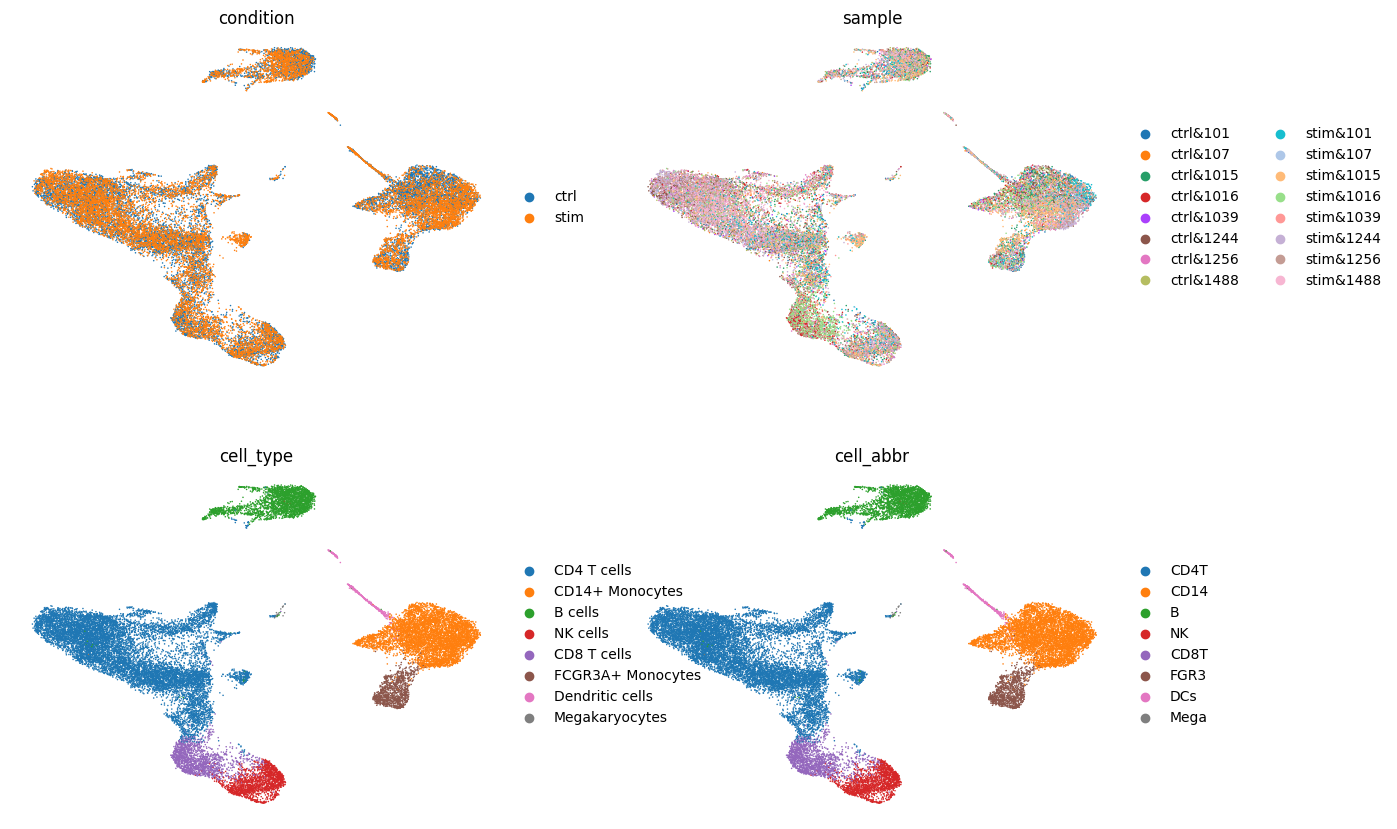

In [6]:
# Show pre-computed UMAP
sc.pl.umap(adata, color=[condition_key, sample_key, 'cell_type', groupby], frameon=False, ncols=2)

## Differential Testing

First, we need to generate pseudobulk profiles for each cell type, and we do so using the [`decoupler` package](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html). 

In [7]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=10000
)
pdata

AnnData object with n_obs × n_vars = 110 × 15701
    obs: 'condition', 'cell_type', 'patient', 'sample', 'cell_abbr', 'psbulk_n_cells', 'psbulk_counts'
    var: 'name', 'n_cells'
    layers: 'psbulk_props'

We can plot the quality control metrics for each pseudobulk sample:

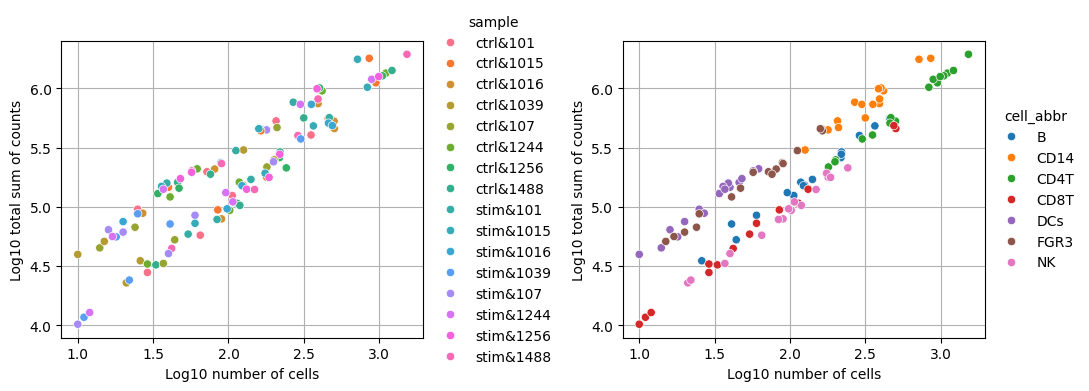

In [8]:
dc.plot_psbulk_samples(pdata, groupby=[sample_key, groupby], figsize=(11, 4))

#### Differential Expression Analysis

Next, now that we have generated the pseudobulk profiles, we can perform some edgeR-like filtering using decoupler-py, and then differential expression analysis using the [`pydeseq2` package](https://pydeseq2.readthedocs.io/en/latest/) - a re-implementation of the original DESeq2 method ([Love et al., 2014](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8?ref=https://githubhelp.com)).

Here, we perform DEA on the pseudobulk profiles for each cell type, for more info check this tutorial:
https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html

In [9]:
%%capture

dea_results = {}
quiet = True

for cell_group in pdata.obs[groupby].unique():
    # Select cell profiles
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()

    # Obtain genes that pass the edgeR-like thresholds
    # NOTE: QC thresholds might differ between cell types, consider applying them by cell type
    genes = dc.filter_by_expr(ctdata,
                              group=condition_key,
                              min_count=5, # a minimum number of counts in a number of samples
                              min_total_count=10 # a minimum total number of reads across samples
                              )

    # Filter by these genes
    ctdata = ctdata[:, genes].copy()
    
    # Build DESeq2 object
    # NOTE: this data is actually paired, so one could consider fitting the patient label as a confounder
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'ctrl'], # set control as reference
        refit_cooks=True,
        quiet=quiet
    )
    
    # Compute LFCs
    dds.deseq2()
    # Contrast between stim and ctrl
    stat_res = DeseqStats(dds, contrast=[condition_key, 'stim', 'ctrl'], quiet=quiet)
    stat_res.quiet = quiet
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff='condition_stim_vs_ctrl') # {condition_key}_cond_vs_ref
    
    dea_results[cell_group] = stat_res.results_df


<div class="alert alert-info">

This results in a wall of currently unavoidable verbose text and prints, as such I use `%%capture` to hide it.
One can use ``quiet`` to some of the functions but not logfc_shrinkage

</div>  


In [10]:
# concat results across cell types
dea_df = pd.concat(dea_results)
dea_df = dea_df.reset_index().rename(columns={'level_0': groupby,'level_1':'index'}).set_index('index')
dea_df.head()

,cell_abbr,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
index,,,,,,,
AAED1,B,7.282872,-0.134222,0.260852,-0.605923,0.544566,0.747988
AAMP,B,11.967019,-0.436867,0.185711,-2.523263,0.011627,0.047688
AARS,B,5.797380,0.180074,0.272438,0.782374,0.433995,0.660342
AASDHPPT,B,6.147571,0.184129,0.305030,0.741856,0.458175,0.679302
AATF,B,9.567191,-0.109027,0.254673,-0.493000,0.622013,0.802867


In [11]:
# PyDeseq Seems to intrdoce NAs for some p-values
# NOTE: there sometimes some NaN being introduced, best to double check that, in this case it's only for a single gene, but it might be a problem.
len(dea_df[dea_df.isna().any(axis=1)])

1

## DEA to Ligand-Receptor Interactions

Now that we have DEA results per gene, we can combine them into statistics of potentially deregulated ligand-receptor interactions.

To do so, liana provides a simple function `li.multi.df_to_lr` that calculates average expression as well as proportions based on the passed `adata` object, and combines those with the DEA results and a ligand-receptor resource. Since in this case we want to focus on gene statics relevant to the condition (stim), let's subset the adata to those and normalize the counts.

In [12]:
adata = adata[adata.obs[condition_key]=='stim'].copy()

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Let's combine the DEA results with the ligand-receptor interactions. We need to pass the names of the statistics from the DEA table in which we are interest to `li.multi.df_to_lr`, here we will use the adjusted p-values and Wald test statistic.

In [14]:
lr_res = li.multi.df_to_lr(adata,
                           dea_df=dea_df,
                           resource_name='consensus', # NOTE: uses HUMAN gene symbols!
                           expr_prop=0.1, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['stat', 'pvalue', 'padj'],
                           use_raw=False,
                           complex_col='stat', # NOTE: we use the Wald Stat to deal with complexes
                           verbose=True,
                           return_all_lrs=False,
                           )

Using resource `consensus`.
Using `.X`!
Converting to sparse csr matrix!
227 features of mat are empty, they will be removed.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
0.75 of entities in the resource are missing from the data.


In [15]:
lr_res = lr_res.sort_values("interaction_stat", ascending=False, key=abs)
lr_res.head()

,ligand,receptor,ligand_complex,receptor_complex,source,ligand_stat,ligand_pvalue,ligand_padj,ligand_expr,ligand_props,...,receptor_pvalue,receptor_padj,receptor_expr,receptor_props,interaction_stat,interaction_pvalue,interaction_padj,interaction_expr,interaction_props,interaction
233,CXCL11,CCR5,CXCL11,CCR5,CD14,26.172426,5.476439e-151,2.599815e-148,3.106561,0.899096,...,9.797079e-47,3.410690e-45,0.601853,0.332369,20.264119,4.898540e-47,1.705345e-45,1.854207,0.615732,CXCL11^CCR5
238,CCL8,CCR5,CCL8,CCR5,CD14,25.720102,6.965891e-146,2.798145e-143,4.313416,0.894756,...,9.797079e-47,3.410690e-45,0.601853,0.332369,20.037957,4.898540e-47,1.705345e-45,2.457634,0.613562,CCL8^CCR5
252,CCL8,CCR1,CCL8,CCR1,CD14,25.720102,6.965891e-146,2.798145e-143,4.313416,0.894756,...,2.567490e-35,5.779065e-34,1.079367,0.552260,19.060759,1.283745e-35,2.889533e-34,2.696391,0.723508,CCL8^CCR1
1062,CXCL11,CCR5,CXCL11,CCR5,FGR3,16.919574,3.227547e-64,6.676057e-62,2.692778,0.826011,...,9.797079e-47,3.410690e-45,0.601853,0.332369,15.637693,4.898540e-47,1.705345e-45,1.647316,0.579190,CXCL11^CCR5
491,CCL8,CCR1,CCL8,CCR1,CD14,25.720102,6.965891e-146,2.798145e-143,4.313416,0.894756,...,2.993682e-07,2.388773e-06,0.384328,0.247232,15.421973,1.496841e-07,1.194386e-06,2.348872,0.570994,CCL8^CCR1



##### Dealing with heteromeric complexes

LIANA will filter lowly-expressed interactions, i.e. those for which any of the genes are not expressed in at least **0.1** of the cells (by default) in the AnnData object. This can be adjusted with the `expr_prop` parameter. 

Moreover, to deal with complexes for each cell type, as either source or target of the potential CCC events, LIANA will find and assign the subunit of a complex with the lowest gene expression (by default) as the subunit of interest, and will then use the stats for that subunit as the stats of the whole protein complex.

<div class="alert alert-info">
This is a simple heuristic also adapted by many other methods, but it is not perfect, as in some cases it might be over-conservative. For example, if the subunit with lowest expression is not the one that is differentially expressed, the complex will not be detected as deregulated.

To this end, we also provide the option to provide a `complex_col` parameter, which will be used to assign the complex subunit of interest. This column should be a part of the `stat_keys`. Note that the **absolute minimum value** is used (i.e. the value closest to 0 is thought to be the 'worst' result), so this will not work for statistics with ascending values (e.g. p-values).
</div>  

## Visualize the Results

<div class="alert alert-success">

`interaction_*` columns returned by `li.multi.dea_to_lr` are just the mean of the ligand and receptor columns of the corresponding statistic!
Please use with caution as this is just a summary of the interaction that we can use to e.g. to sort the interactions as done above.
Instead, we recommend to use the ligand and receptor statistics **separately** to filter and visualize the interactions.

</div>

Moreover, by averaging the statistics across the ligand and receptor, we  are focusing on the interactions for which both the ligand and receptor are deregulated in the same direction, i.e. both up or both down. However, this might ignore interactions in which e.g. the the ligand is deregulated while the receptor is not, or such where they are deregulated in opposite directions. These could represent potential inhibitory mechanisms, but we leave this to the user to explore.



<Axes: >

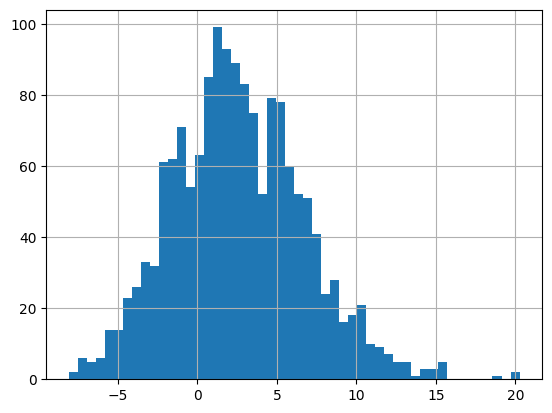

In [16]:
# Let's visualize how this looks like for all interactions  (across all cell types)
lr_res = lr_res.sort_values("interaction_stat", ascending=False)
lr_res['interaction_stat'].hist(bins=50)

Now that we have covered the basics, we can visualize our interactions in a few ways. 

Let's start with the top interactions according to their Wald statistic, and then plot the statistics for the ligands & receptors involved in those interactions across cell types, to do so LIANA+ provide `li.pl.tileplot`:

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 54 rows containing missing values.
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


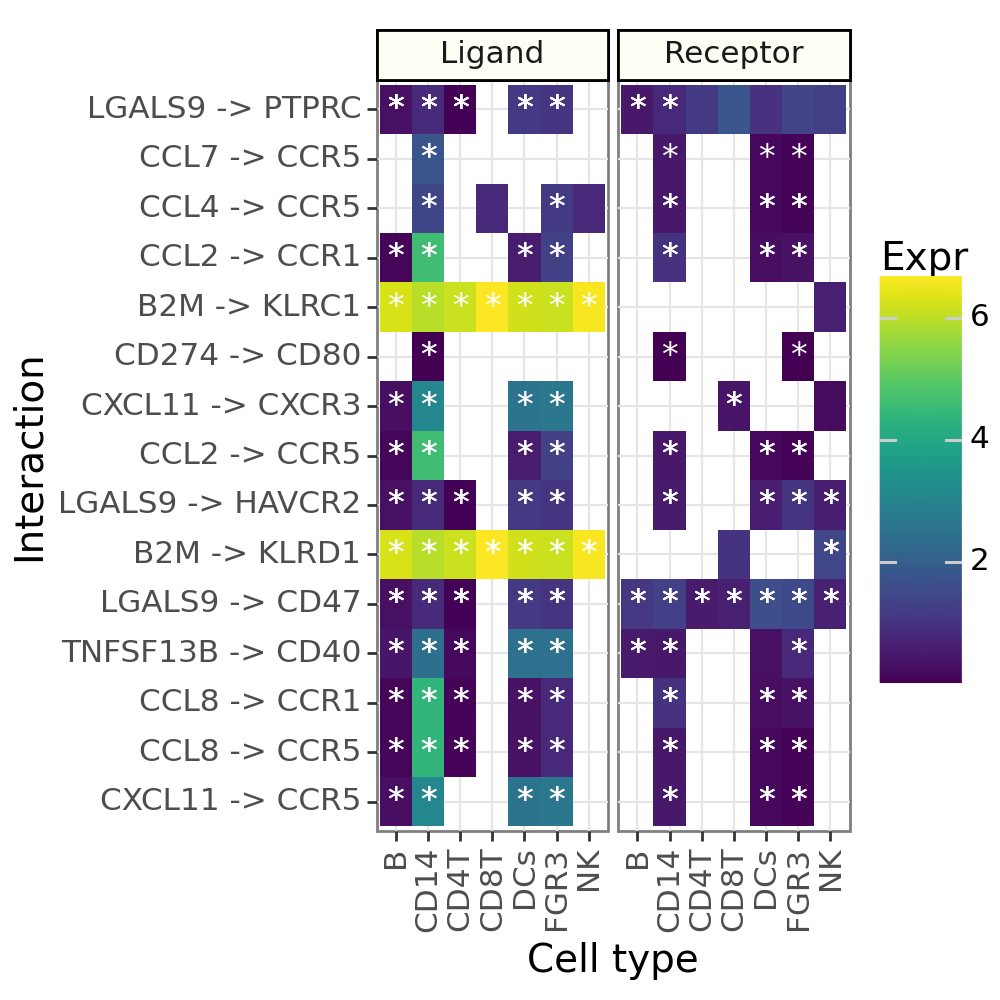

<Figure Size: (500 x 500)>

In [17]:
li.pl.tileplot(liana_res=lr_res,
               fill = 'expr',
               label='padj',
               label_fun = lambda x: '*' if x < 0.05 else np.nan,
               top_n=15,
               orderby = 'interaction_stat',
               orderby_ascending = False,
               orderby_absolute = False,
               source_title='Ligand',
               target_title='Receptor',
               )

If you want to plot the expression values for ligand-receptor interactions without the DEA statistics, you can set the `return_all_lrs` parameter to `True` in the `li.multi.dea_to_lr` function. This will return a dataframe with all the ligand-receptor interactions, where missing DEA stats will be set as `nan`, while mean expression and proportions per cluster will be obtained via the AnnData object.

### Ligand-Receptor Plot

We can also use visualize of the stats, summarized at the level of the interaction, to prioritize the interactions, or any subunit statistics using `li.pl.dotplot`. For example, we can visualize the mean Wald statistic between the ligand & receptor, together with the pvalues for the ligand.

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_color_cmap could not recognise parameter `midpoint`
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


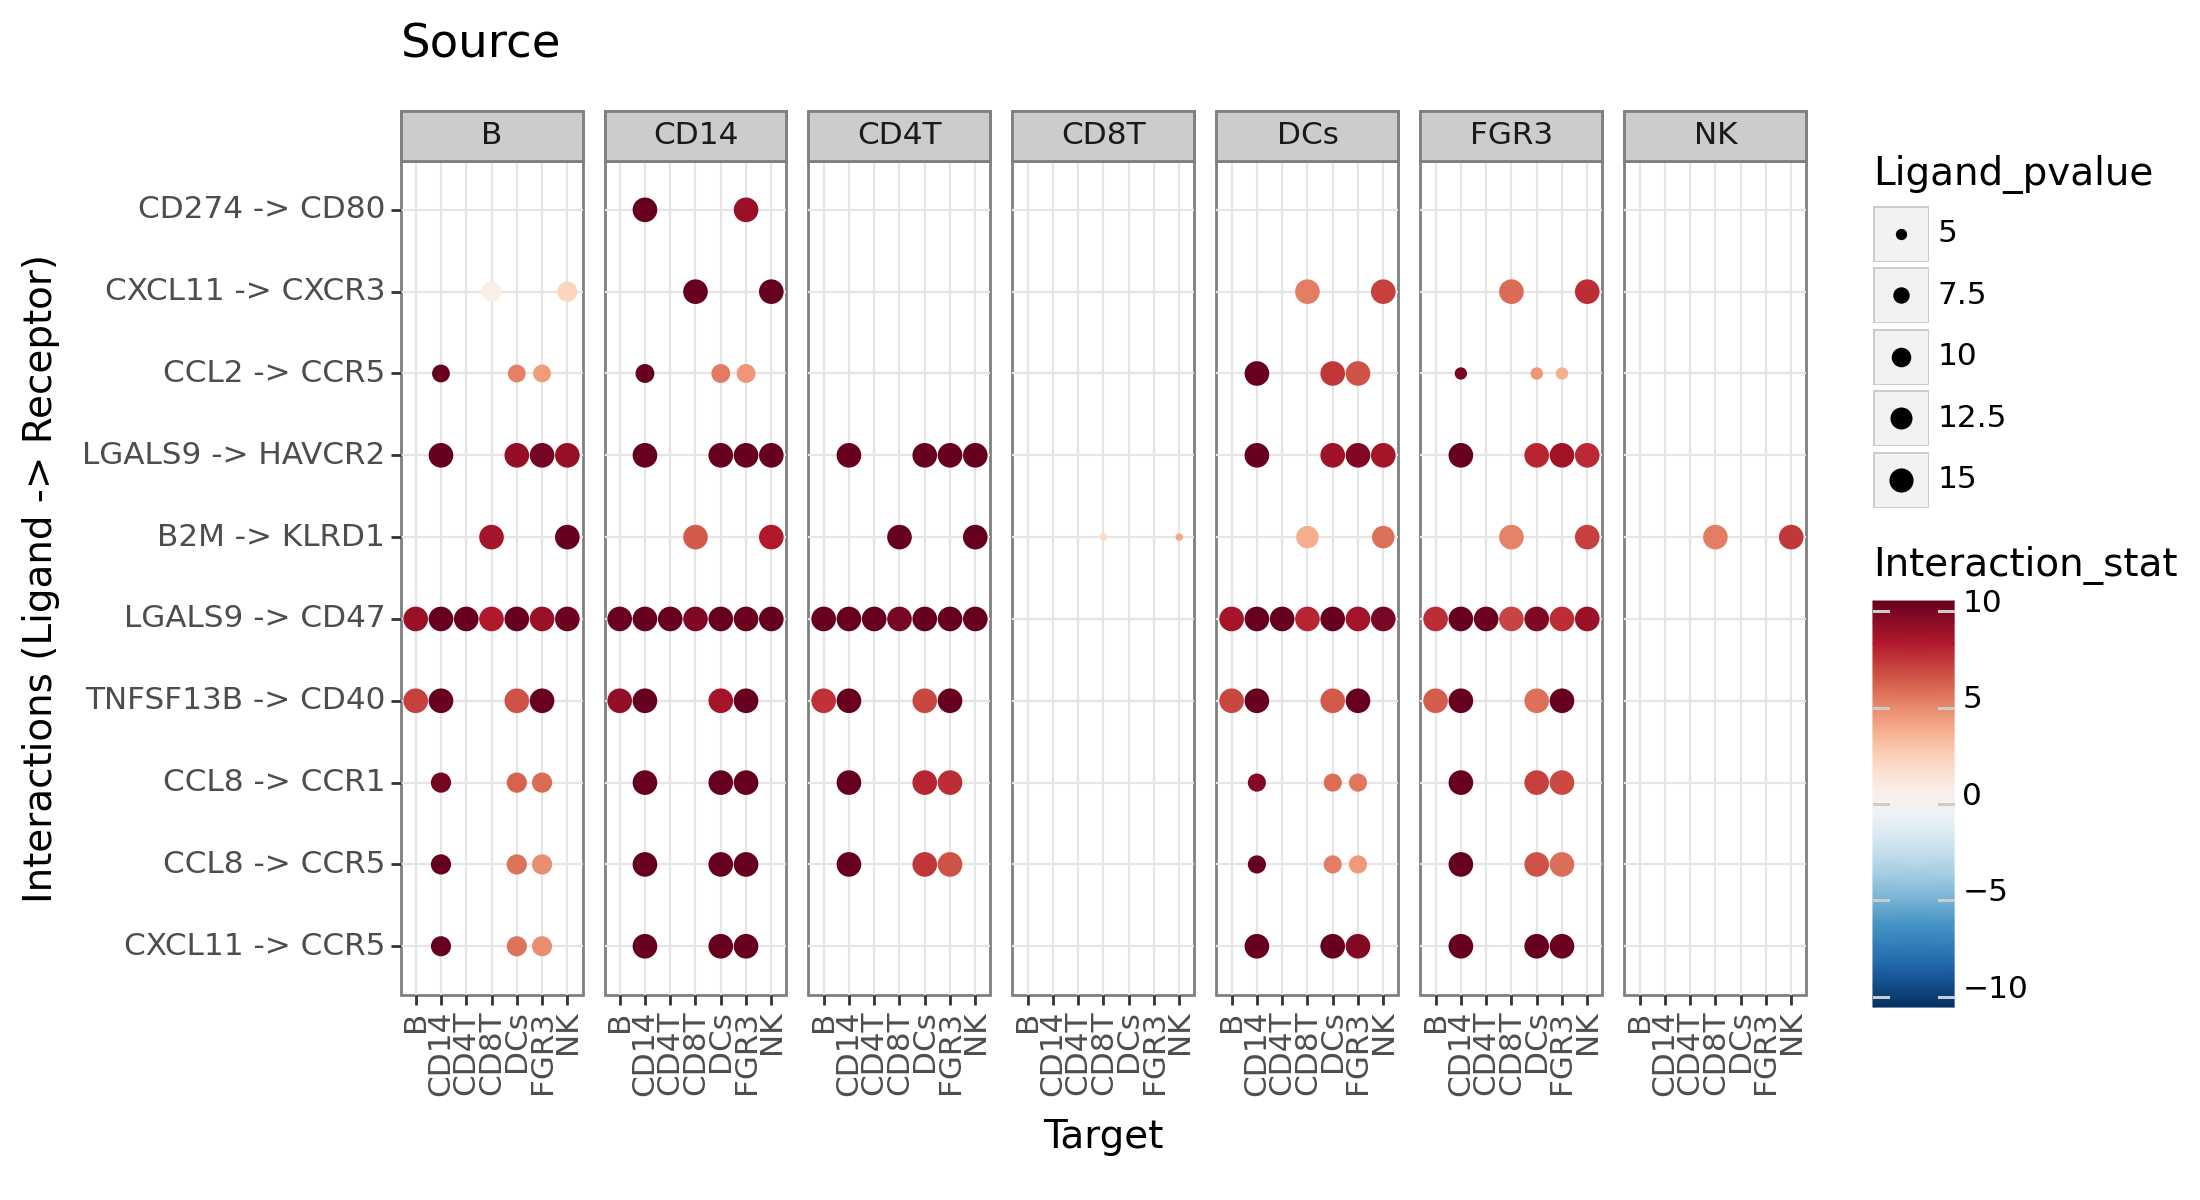

<Figure Size: (1100 x 600)>

In [18]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='ligand_pvalue',
                     inverse_size=True,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     orderby_absolute=True,
                     top_n=10,
                     size_range=(0.5, 4)
                     )

# customize plot
(
    plot
    + p9.theme_bw(base_size=14)
    # fill cmap blue to red, with 0 the middle
    + p9.scale_color_cmap('RdBu_r', midpoint=0, limits=(-10, 10))
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(11, 6))

)

Now that we have identified a set of interactions that are potentially deregulated we can look into the downstream signalling events that they might be involved in.

<div class="alert alert-info">
  One can also estimate ligand-receptor pathway activities, etc, these are covered multiple times in other tutorials, but also are applicable here.
</div>

## Intracellular Signaling Networks

Cellular signaling networks govern the behavior of cells, allowing them to respond to external signals, including various cell-cell communication events. Thus, CCC events can be thought of as upstream perturbants of intracellular signaling networks that lead to deregulations of downstream signaling events. Such deregulations are expected to be associated with various conditions and disease. Thus, understanding intracellular signaling networks is critical to model the cellular mechanisms.

Here, we will combine several tools to identify plausible signalling cascades driven by CCC events.

Our approach includes the following steps:

* Select a number of potentially deregulated ligand-receptor interactions (input nodes), in terms of summarized PyDESeq2 statistics.

* Select a number of potentially deregulated TFs (output nodes). This is done via the use of Transcription factor (TF) activity inference. Carried out on differential gene expression data using [TF regulon knowledge](https://github.com/saezlab/CollecTRI) with [decoupler](https://github.com/saezlab/decoupler-py)

* Obtain a prior knowledge network (PKNs), with signed protein-protein interactions from OmniPath.

* Generate weights for the nodes in the PKN

* Use CORNETO to identify a solution in the form of a [causal (smallest sign-consistent signaling) network](https://www.nature.com/articles/s41540-019-0118-z) that explains the measured inputs and outputs

<img src="causal-networks.png" width=800 />




### Import OmniPath

For this part OmniPath is required.
```{python}
pip install omnipath
```

In [19]:
# utily function to select top n interactions
def select_top_n(d, n=None):
    d = dict(sorted(d.items(), key=lambda item: abs(item[1]), reverse=True))
    return {k: v for i, (k, v) in enumerate(d.items()) if i < n}

### Select Cell types of Interest

One limitation of using DEA to identify interactions of interest is that it tells us little about deregulation at the level of cell types.
However, from dimensionality reductions on CCC, as done with [Tensor-cell2cell](https://liana-py.readthedocs.io/en/latest/notebooks/liana_c2c.html) & [MOFA](https://liana-py.readthedocs.io/en/latest/notebooks/mofatalk.html#) on the same dataset, we can see there is a potential deregulation of CCC that involve CD14 monocytes both as sources (senders) and targets (or receivers) of intecellular communication. Thus, we will focus on the interactions and downstream signalling within that cell type.

In [20]:
source_label = 'CD14'
target_label = 'CD14'

# NOTE: We sort by the absolute value of the interaction stat
lr_stats = lr_res[lr_res['source'].isin([source_label]) & lr_res['target'].isin([target_label])].copy()
lr_stats = lr_stats.sort_values('interaction_stat', ascending=False, key=abs)

### Select Receptors based on interaction stats

These will be used as the input or start nodes for the network. In this case, we will use interactions potentially involved in autocrine signalling in CD14 monocytes.

In [21]:
lr_dict = lr_stats.set_index('receptor')['interaction_stat'].to_dict()
input_scores = select_top_n(lr_dict, n=10)

In [22]:
input_scores

{'CD40': 15.213890738775456,
 'CD80': 11.672283052638337,
 'SIRPA': 9.92679527367514,
 'CCR1': 9.12729237916692,
 'HLA-DPB1': 8.625121687728944,
 'LILRB2': 8.250712282572682,
 'CCR5': 6.024106443619973,
 'PTPRC': 5.811339038637888,
 'LILRB1': 5.586746654720494,
 'CD47': 5.431274692175629}

### Select Transcription Factors of interest

Before we select the transcription factors, we need to infer their activity. We will do so using [decoupler](https://github.com/saezlab/decoupler-py) with [CollecTri](https://github.com/saezlab/CollecTRI) regulons. Specifically, we will estimate TF activities using the Wald statistics (from PyDESeq2) for the genes in the regulons.

In [23]:
# First, let's transform the DEA statistics into a DF
# we will use these to estimate deregulated TF activity
dea_wide = dea_df[[groupby, 'stat']].reset_index(names='genes').pivot(index=groupby, columns='genes', values='stat')
dea_wide = dea_wide.fillna(0)
dea_wide

genes,A1BG,AAAS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARSD1,...,ZSCAN16,ZSCAN16-AS1,ZSCAN18,ZSCAN32,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZYX,ZZZ3
cell_abbr,,,,,,,,,,,,,,,,,,,,,
B,0.000000,0.000000,-0.605923,0.000000,0.000000,0.000000,-2.523263,0.000000,0.782374,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-2.350376,0.000000,0.00000,0.000000,0.000000
CD14,-2.993111,0.000000,10.129553,0.000000,1.085436,6.968489,-3.097932,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.281381,-4.154833,1.737279,0.00000,-1.796965,0.000000
CD4T,-2.814957,-1.995631,0.191978,1.144712,-5.150155,-0.081141,-0.650599,2.032146,1.648662,-0.270347,...,-0.218578,-1.168355,-1.515016,-0.430795,0.000000,-1.685312,3.455590,-0.17713,-1.399221,-0.240491
CD8T,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
DCs,0.000000,0.000000,3.883796,0.000000,0.000000,0.000000,-1.620856,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-2.573142,0.000000
FGR3,0.000000,0.000000,2.836840,0.000000,0.000000,0.000000,-3.248816,0.000000,0.000000,0.000000,...,4.160610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-2.117717,0.000000
NK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.548184,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [24]:
# Run Enrichment Analysis
estimates, pvals = dc.run_ulm(mat=dea_wide, net=net)
estimates.T.sort_values(target_label, key=abs, ascending=False).head()

,B,CD14,CD4T,CD8T,DCs,FGR3,NK
STAT1,17.926670,13.178566,16.732069,17.533529,17.887823,15.023597,16.353252
IRF1,15.773025,10.694732,14.545148,13.118623,14.475640,11.968679,13.322178
STAT2,14.908431,9.841800,12.172835,13.719251,15.724816,12.524464,12.979574
IRF9,18.450977,8.841106,14.894291,19.616129,17.128387,13.703831,17.811499
NFKB1,6.898114,7.734655,8.250937,5.890799,9.258309,8.580269,7.130418


### Select top TFs

Now that we have the potentially deregulated TFs, we focus on the top 10 TFs, based on their enrichment scores. In this case, we will look specifically at the top TFs deregulated in CD14 monocytes.

In [25]:
tf_data = estimates.copy()
tf_dict = tf_data.loc[target_label].to_dict()
output_scores = select_top_n(tf_dict, n=5)

### Generate a Prior Knowledge Network

Now we will obtain protein-protein interactions from [OmniPath](https://github.com/saezlab/omnipath), filter them according to curation effort to ensure we only keep those that are of high quality, and convert them into a knowledge graph.

In [26]:
# obtain ppi network
ppis = op.interactions.OmniPath().get(genesymbols = True)

ppis['mor'] = ppis['is_stimulation'].astype(int) - ppis['is_inhibition'].astype(int)
ppis = ppis[(ppis['mor'] != 0) & (ppis['curation_effort'] >= 5) & ppis['consensus_direction']] 

input_pkn = ppis[['source_genesymbol', 'mor', 'target_genesymbol']]
input_pkn.columns = ['source', 'mor', 'target']
input_pkn.head()

,source,mor,target
3,CAV1,1,TRPC1
6,ITPR2,1,TRPC1
9,STIM1,1,TRPC1
10,TRPC1,1,TRPC3
11,TRPC3,1,TRPC1


In [27]:
# convert the PPI network into a knowledge graph
prior_graph = li.mt.build_prior_network(input_pkn, input_scores, output_scores, verbose=True)

Importing network...


done.
 - Nodes x Edges: (3115, 6157)
 - Provided inputs included in the prior network: 8/10
 - Provided outputs included in the network: 5/5
Performing reachability analysis...
done.
 - Selected inputs: 4/8.
 - Selected outputs: 5/5.
 - Final size of the prior graph: (530, 1988).


In this section we use Prior Knowledge Networks (PKNs) from OmniPath to generate network hypotheses based on the deregulated interactions considering both sign and direction. Specifically, we focus on highly curated protein-protein interactions, which often represent hubs in the network. Since such network approaches are highly dependent on prior knowledge, for a review on prior knowledge bias and similar network inference methods, including thier limitations, see [Garrido-Rodriguez et al., 2022](https://www.embopress.org/doi/full/10.15252/msb.202211036).

### Calculate Node weights

Calculate gene expression proportions within the target cell type; we will use those as node weights in the network.

In [28]:
temp = adata[adata.obs[groupby] == target_label].copy()

In [29]:
node_weights = pd.DataFrame(temp.X.getnnz(axis=0) / temp.n_obs, index=temp.var_names)
node_weights = node_weights.rename(columns={0: 'props'})
node_weights = node_weights['props'].to_dict()

### Find Causal Network


[CORNETO](https://github.com/saezlab/corneto) (Rodriguez-Mier et al., In prep) generalizes biological network inference problems using convex and combinatorial optimization. Here, we use it to find the smallest sign-consistent network that explains the measured inputs and outputs, a network inference problem formulated in [CARNIVAL](https://www.nature.com/articles/s41540-019-0118-z).

<div class="alert alert-info">
CORNETO further generalizes the use of different solvers to find the network inference problems, as such it supports  a wide range of supported free and commercial solvers. If no additional solver is installed (as done here), it will default to using the solver included in SCIPY. 
We refer the user to the CORNETO documentation for more details on how to use different solvers, specifically if they wish to solve more complex examples than the one presented here.
</div>

To run CORNETO, we need to first install it; it's very lightweight and can be installed via pip:

```python
pip install corneto cvxpy cylp
```


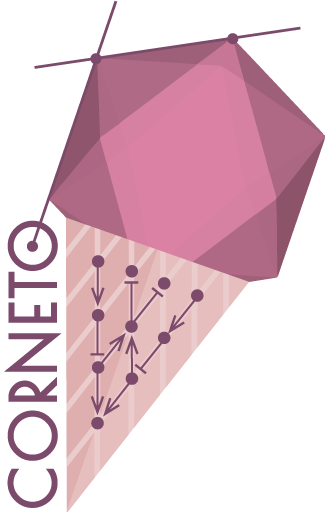

In [30]:
import corneto as cn
cn.info()

In [31]:
df_res, problem = li.mt.find_causalnet(
    prior_graph, 
    input_scores, 
    output_scores, 
    node_weights,
    # penalize (max_penalty) nodes with counts in less than 0.1 of the cells
    node_cutoff=0.1, 
    max_penalty=1,
    # the penaly of those in > 0.1 prop of cells set to:
    min_penalty=0.01,
    edge_penalty=0.1,
    verbose=False,
    max_runs=50, # NOTE that this repeats the solving either until the max runs are reached
    stable_runs=10, # or until X number of consequitive stable runs are reached (i.e. no new edges are added)
    solver='gurobi' # 'scipy' is available by default, but often results in suboptimal solutions
    )

Set parameter Username


Set parameter Username


Academic license - for non-commercial use only - expires 2025-01-26


Academic license - for non-commercial use only - expires 2025-01-26


### Visualize the Inferred Network

Now that the solution has been found, we can visualize it using the `cn.methods.carnival.visualize_network` function.

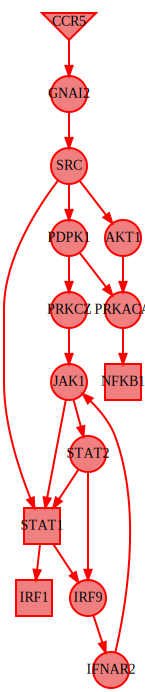

In [32]:
cn.methods.carnival.visualize_network(df_res)

We can see that the network above, largely captures a potential regulatory cascade with inhibitory (**--|**) and stimulatory (**-->**) interactions, related to JAK-STAT signalling. The network, in this case, starts from a receptor (**triangle**), coming from the top interactions, and ends with the deregulated TFs (**square**). The remainder of the nodes (**circles**) were inferred, taking their weights into account, and were not necessarily included in the input or output nodes.

In this example, we represent the directionality of signalling such that intracellular signalling is downstream of intercellular communication events. However, in biology cellular response is an admixture of both; thus such approaches are a simplification of biological reality.

### Describe Results

Let's examine the result of the subnetwork search - it provides information about the predicted signs of nodes and edges.

In [36]:
df_res.head()

,source,source_type,source_weight,source_pred_val,target,target_type,target_weight,target_pred_val,edge_type,edge_pred_val
0,PRKCZ,unmeasured,0.0,1.0,JAK1,unmeasured,0.000000,1.0,1,1.0
1,STAT1,unmeasured,0.0,1.0,IRF1,output,10.694732,1.0,1,1.0
2,PRKACA,unmeasured,0.0,1.0,NFKB1,output,7.734655,1.0,1,1.0
3,SRC,unmeasured,0.0,1.0,PDPK1,unmeasured,0.000000,1.0,1,1.0
4,GNAI2,unmeasured,0.0,1.0,SRC,unmeasured,0.000000,1.0,1,1.0


#### Nodes
- **source**: source nodes in the Protein-Protein Interaction (PPI) network. Suffixes such as "_s," "_pert_c0," and "_meas_c0" indicate specific experimental conditions or measurement types (they are there simply because of how the ILP problem is formulated, and can be ignored).
- **target**: target nodes in the PPI network, with suffixes similar to the source node.

- **source_type (unmeasured, input)**: 
  - **input**: start nodes (provided by the users, here receptors).
  - **output**: end nodes (provides by the user, here transcription factors).
  - **unmeasured**: Nodes that are neither input nor output - i.e. those that predicted by the algorithm.
- **source_weight** and **target_weight**: Inputs to the causal net method, indicating the influence of "measured" nodes within the network. Only the sign is taken into account.
- **source_pred_val (1, 0, -1)**: Regulatory state of the node:
  - **1**: Upregulated
  - **0**: No differential expression
  - **-1**: Downregulated
- **target_pred_val (1, -1)**: Regulatory state of the target node:
  - **1**: Upregulated
  - **-1**: Downregulated

#### Edges (interaction)
- **edge_type (1, -1, 0)**: Type of interaction from prior knowledge:
  - **1**: Activating interaction (e.g., A -> B)
  - **-1**: Inhibitory interaction
- **edge_pred_val (1, -1)**: Predicted effect of the interaction on the target node:
  - **1**: Upregulation
  - **-1**: Downregulation


### Installing the Gurobi Solver: A Step-by-Step Guide

While in this small example the internal scipy solver works, for larger networks we recommend using a solver such as Gurobi.

Gurobi is a powerful optimization solver used in various mathematical programming problems. Here's how you can install it:

#### 1. Download Gurobi for Your Operating System:
Visit the [Gurobi download page](https://support.gurobi.com/hc/en-us/articles/4534161999889) and select the version compatible with your OS.

#### 2. Unzip and Update Path:
After downloading, unzip the file. Locate the `/bin` folder inside the unzipped directory and add it to your system's `$PATH` variable. This step is crucial as it allows your system to recognize and run Gurobi from anywhere.

#### 3. Register for an Academic License:
If you're an academic user, you can obtain a free license. Register and request an academic license through the [Gurobi portal](https://portal.gurobi.com/). Follow the prompts to complete your registration.

#### 4. Install Gurobi Python Interface:
Open your command prompt or terminal and run:

```pip install gurobipy```

This command installs the necessary Python interface to interact with Gurobi.

#### 5. Configure the Solver:
In your code, ensure the `solver` parameter is set to `gurobi` to direct your program to use the Gurobi solver.

By following these steps, you should have Gurobi installed and ready to tackle complex optimization problems.

